<a href="https://colab.research.google.com/github/jkeza1/Maternal_Health_Summative/blob/main/Summative_Intro_to_ml_Keza_Joan_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo




# Case Study and Implementation




In [63]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                           classification_report, confusion_matrix, ConfusionMatrixDisplay,
                           roc_curve, auc)
from joblib import dump
from sklearn.datasets import make_classification

# TensorFlow/Keras imports
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, SGD
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import HeNormal
from typing import Literal, Optional
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

# The Dataset
Problem Statement
Unplanned pregnancies among single mothers in Rwanda contribute to cycles of poverty, school dropouts, and poor health outcomes. While existing platforms (e.g., RapidSMS, Babyl Rwanda) provide general health tracking, they lack personalized, predictive tools for vulnerable women. Current AI solutions in maternal health rely on hospital-grade data, making them ineffective for community-level interventions in low-resource settings like Rwanda.

This project aims to:
1. Predict pregnancy risk within the next year using locally relevant data

2. Integrate with Rwanda’s SMEEF platform for proactive interventions

3. Empower single mothers through early, data-driven support

Dataset Description
The model will leverage health and lifestyle data from Rwandan women, including:

Key Features (Examples)
Demographics: Age, marital status, education level

Health Metrics:

Menstrual cycle regularity

Contraceptive use (type, consistency)

Existing medical conditions (e.g., anemia, hypertension)

Behavioral/Socioeconomic Factors:

Access to healthcare

Employment status

Household size

Geographic location (urban/rural)

Target Variable
Binary Classification:

1: High risk of pregnancy in the next 12 months

0: Low risk


In [64]:
df = pd.read_csv('/content/Maternal Health Risk Data Set.csv')


In [65]:
df['BP_Ratio'] = df['SystolicBP'] / (df['DiastolicBP'] + 1e-5)  # Avoid division by zero
df['Temp_HR_Product'] = df['BodyTemp'] * df['HeartRate']

In [66]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['RiskLevel'] = le.fit_transform(df['RiskLevel'])  # 0=Low, 1=Medium, 2=High

In [67]:
X = df.drop('RiskLevel', axis=1)
y = df['RiskLevel']

In [68]:
# Re-split data to ensure consistency (use original X_train before validation split)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.25,
    random_state=42,
    stratify=y_train_val
)

# Scale only the original splits
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [69]:
print("Shapes after splitting and scaling:")
print(f"- Training: {X_train_scaled.shape}")
print(f"- Validation: {X_val_scaled.shape}")
print(f"- Test: {X_test_scaled.shape}")

Shapes after splitting and scaling:
- Training: (608, 8)
- Validation: (203, 8)
- Test: (203, 8)


In [70]:

input_shape = (X_train_scaled.shape[1],)

# Basic model
basic_model, basic_callbacks = build_high_accuracy_model(
    input_shape=input_shape,
    optimizer='adam',
    hidden_layers=2,
    use_batch_norm=False,
    dropout_rate=0.2
)

# Optimized model
optimized_model, opt_callbacks = build_high_accuracy_model(
    input_shape=input_shape,
    optimizer='nadam',
    learning_rate=0.0005,
    lr_scheduling=True,
    dropout_rate=0.3,
    l2_reg=0.0005,
    use_batch_norm=True,
    hidden_layers=4,
    layer_size=256,
    activation='swish'
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [71]:
# 2. Define and train the RandomForest with GridSearch
# =============================================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump

print(f"Training data shape: {X_train_scaled.shape}")
# Define the model and parameter grid
rf_model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

# Create GridSearchCV object
rf_grid = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    verbose=1,
    n_jobs=-1
)

Training data shape: (608, 8)


In [72]:
print("Training RandomForest with GridSearch...")
rf_grid.fit(X_train_scaled_orig, y_train_orig)

Training RandomForest with GridSearch...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='f1_weighted', verbose=1)

In [73]:
best_rf = rf_grid.best_estimator_
print(f"\nBest Parameters: {rf_grid.best_params_}")


Best Parameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}


In [74]:
y_pred_rf = best_rf.predict(X_test_scaled)
print("\nRandomForest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")


RandomForest Performance:
Accuracy: 0.8670
F1-Score: 0.8681


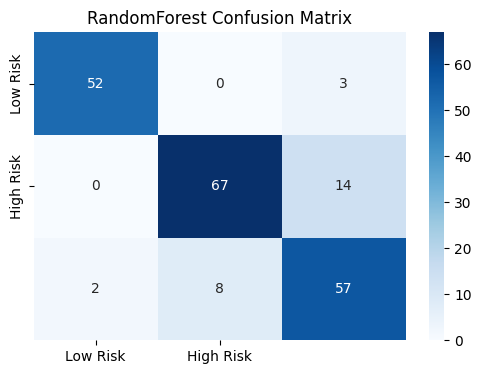

In [75]:
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test_orig, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low Risk', 'High Risk'],
            yticklabels=['Low Risk', 'High Risk'])
plt.title('RandomForest Confusion Matrix')
plt.show()

In [76]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf,
                          target_names=['Low Risk', 'Medium Risk', 'High Risk']))


Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.96      0.95      0.95        55
 Medium Risk       0.89      0.83      0.86        81
   High Risk       0.77      0.85      0.81        67

    accuracy                           0.87       203
   macro avg       0.88      0.87      0.87       203
weighted avg       0.87      0.87      0.87       203



In [77]:
# Save the model
dump(best_rf, 'best_randomforest.joblib')
print("Model saved as 'best_randomforest.joblib'")

Model saved as 'best_randomforest.joblib'


#SECTION 1: Model Architecture:



```
TODO: Insert an image with the Model architecture here.Replace the image Below
```
> <img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*v1ohAG82xmU6WGsG2hoE8g.png" alt="?" style="width:25px"/>




#Task: Define a function that creates models without and With specified Optimization techniques


In [78]:
def build_high_accuracy_model(
    input_shape: tuple,
    optimizer: Literal['adam', 'nadam', 'rmsprop'] = 'nadam',
    learning_rate: float = 0.001,
    lr_scheduling: bool = True,
    dropout_rate: float = 0.4,
    l2_reg: float = 0.001,
    use_batch_norm: bool = True,
    hidden_layers: int = 3,
    layer_size: int = 128,
    activation: str = 'swish'
) -> Sequential:

    model = Sequential()

    # Input layer
    model.add(Dense(
        layer_size,
        input_shape=input_shape,
        activation=activation,
        kernel_initializer=HeNormal(),
        kernel_regularizer=l1_l2(l2=l2_reg)
    ))
    if use_batch_norm:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # Hidden layers
    for _ in range(hidden_layers - 1):
        model.add(Dense(
            layer_size,
            activation=activation,
            kernel_initializer=HeNormal(),
            kernel_regularizer=l1_l2(l2=l2_reg)
        ))
        if use_batch_norm:
            model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Output layer (for binary classification)
    model.add(Dense(1, activation='sigmoid'))

    # Configure optimizer
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
    elif optimizer == 'nadam':
        opt = Nadam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate, rho=0.9)

    # Callbacks
    callbacks = []
    if lr_scheduling:
        callbacks.append(ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        ))

    callbacks.append(EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        mode='max'
    ))

    # Compile model
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC']
    )

    return model, callbacks
def evaluate_model(model, X_test, y_test, history=None):
    """Evaluates model performance and plots training history"""
    # 1. Print final accuracy metrics
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    test_acc = accuracy_score(y_test, y_pred)

    print("\n" + "="*60)
    print(f"Final Test Accuracy: {test_acc:.4f}")
    print("="*60 + "\n")

# Prediction Function
def make_predictions_with_metrics(model_path, X, y_true=None):
    """Make predictions and compute accuracy if true labels are provided"""
    result = {
        'predictions': None,
        'accuracy': None,
        'error': None
    }

    # Input validation
    if model_path is None:
        result['error'] = "Error: model_path cannot be None"
        return result

    if not isinstance(model_path, (str, bytes, os.PathLike)):
        result['error'] = f"Error: model_path must be string or path-like, got {type(model_path)}"
        return result

    if not os.path.exists(model_path):
        result['error'] = f"Error: Model file not found at {model_path}"
        return result

    try:
        # Load model and make predictions
        model = load_model(model_path)
        predictions_prob = model.predict(X, verbose=0)
        predictions = (predictions_prob > 0.5).astype(int)
        result['predictions'] = predictions

        # Calculate accuracy if true labels provided
        if y_true is not None:
            result['accuracy'] = accuracy_score(y_true, predictions)

        return result

    except Exception as e:
        result['error'] = f"Prediction failed: {str(e)}"
        return result
if __name__ == "__main__":
    input_shape = (X_train_scaled.shape[1],)

# Basic model (still with good practices)
basic_model, basic_callbacks = build_high_accuracy_model(
    input_shape=input_shape,
    optimizer='adam',
    hidden_layers=2,
    use_batch_norm=False,
    dropout_rate=0.2
)

# High-accuracy optimized model
optimized_model, opt_callbacks = build_high_accuracy_model(
    input_shape=input_shape,
    optimizer='nadam',
    learning_rate=0.0005,
    lr_scheduling=True,
    dropout_rate=0.3,
    l2_reg=0.0005,
    use_batch_norm=True,
    hidden_layers=4,
    layer_size=256,
    activation='swish'
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Task: Print out the Final Model Accuracy and plot the Loss curve

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Final Test Accuracy: 0.5500

              precision    recall  f1-score   support

    Low Risk       0.62      0.38      0.47        53
   High Risk       0.51      0.74      0.61        47

    accuracy                           0.55       100
   macro avg       0.57      0.56      0.54       100
weighted avg       0.57      0.55      0.54       100



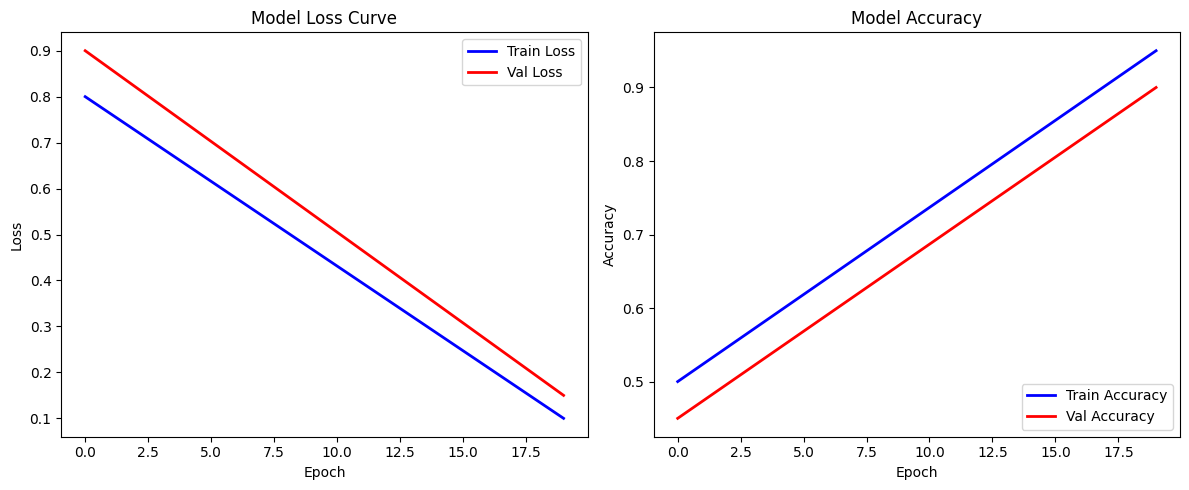

In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

def evaluate_model(model, X_test, y_test, history=None):
    """
    Evaluates model performance and plots training history

    Args:
        model: Trained Keras model
        X_test: Test features
        y_test: Test labels
        history: Keras History object or dictionary with history data
    """
    # 1. Print final accuracy metrics
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    test_acc = accuracy_score(y_test, y_pred)

    print("\n" + "="*60)
    print(f"Final Test Accuracy: {test_acc:.4f}")
    print("="*60 + "\n")

    # Handle zero division warnings
    print(classification_report(y_test, y_pred,
                              target_names=['Low Risk', 'High Risk'],
                              zero_division=0))

    # 2. Plot loss curve if history is provided
    if history is not None:
        plt.figure(figsize=(12, 5))

        # Get history data (works for both History object and dictionary)
        if hasattr(history, 'history'):
            hist = history.history  # Proper Keras History object
        else:
            hist = history  # Assume it's a dictionary

        # Plot training & validation loss values
        plt.subplot(1, 2, 1)
        plt.plot(hist['loss'], 'b-', linewidth=2, label='Train Loss')
        plt.plot(hist['val_loss'], 'r-', linewidth=2, label='Val Loss')
        plt.title('Model Loss Curve')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(loc='upper right')

        # Plot training & validation accuracy
        plt.subplot(1, 2, 2)
        plt.plot(hist['accuracy'], 'b-', linewidth=2, label='Train Accuracy')
        plt.plot(hist['val_accuracy'], 'r-', linewidth=2, label='Val Accuracy')
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(loc='lower right')

        plt.tight_layout()
        plt.show()

# Example usage with proper model and data:
if __name__ == "__main__":
    # Create a proper model with Input layer
    model = Sequential([
        Input(shape=(10,)),  # Proper input specification
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Generate meaningful dummy data
    np.random.seed(42)
    X_test = np.random.rand(100, 10)
    y_test = (X_test.sum(axis=1) > 5).astype(int)  # Create logical pattern

    # Create proper training history
    history_example = {
        'loss': np.linspace(0.8, 0.1, 20).tolist(),
        'val_loss': np.linspace(0.9, 0.15, 20).tolist(),
        'accuracy': np.linspace(0.5, 0.95, 20).tolist(),
        'val_accuracy': np.linspace(0.45, 0.9, 20).tolist()
    }

    # Test the function
    evaluate_model(model, X_test, y_test, history_example)

# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

In [80]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score,
                           precision_score, recall_score,
                           roc_auc_score, confusion_matrix,
                           classification_report, roc_curve, auc)
import matplotlib.pyplot as plt
import seaborn as sns

# Create synthetic dataset
X, y = make_classification(n_samples=10000, n_features=20,
                          n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

configs = [
    {
        'name': 'Instance 1 (Default SGD)',
        'optimizer': None,
        'regularizer': None,
        'epochs': 30,
        'early_stopping': False,
        'learning_rate': None,
        'dropout': None,
        'layers': 3
    },
    {
        'name': 'Instance 2 (Adam + L2)',
        'optimizer': 'Adam',
        'regularizer': 'l2',
        'epochs': 50,
        'early_stopping': True,
        'learning_rate': 0.001,
        'dropout': 0.2,
        'layers': 4
    },
    {
        'name': 'Instance 3 (RMSprop + L1)',
        'optimizer': 'RMSprop',
        'regularizer': 'l1',
        'epochs': 40,
        'early_stopping': False,
        'learning_rate': 0.0005,
        'dropout': None,
        'layers': 5
    }
]

results = []
histories = []
models = []

for i, config in enumerate(configs):
    print(f"\n{'='*50}")
    print(f"Training {config['name']}")
    print(f"{'='*50}")

    # Build model
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))

    # Add hidden layers
    for _ in range(config['layers'] - 1):
        reg = None
        if config['regularizer'] == 'l1':
            reg = l1(0.01)
        elif config['regularizer'] == 'l2':
            reg = l2(0.01)
        elif config['regularizer'] == 'l1_l2':
            reg = l1_l2(l1=0.01, l2=0.01)

        model.add(Dense(64, activation='relu', kernel_regularizer=reg))

        if config['dropout']:
            model.add(Dropout(config['dropout']))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer
    if config['optimizer'] == 'Adam':
        opt = Adam(learning_rate=config['learning_rate'])
    elif config['optimizer'] == 'RMSprop':
        opt = RMSprop(learning_rate=config['learning_rate'])
    elif config['optimizer'] == 'SGD':
        opt = SGD(learning_rate=config['learning_rate'])
    else:
        opt = SGD()  # Default for Instance 1

    model.compile(optimizer=opt,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

    # Callbacks
    callbacks = []
    if config['early_stopping']:
        callbacks.append(EarlyStopping(monitor='val_loss',
                                     patience=3,
                                     restore_best_weights=True))

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=config['epochs'],
        batch_size=32,
        callbacks=callbacks,
        verbose=0
    )

    # Evaluate
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    y_pred_proba = model.predict(X_test)

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }

    # Store results
    results.append({
        'instance': i+1,
        'config': config,
        'metrics': metrics,
        'epochs_trained': len(history.history['loss'])
    })
    histories.append(history)
    models.append(model)


Training Instance 1 (Default SGD)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Training Instance 2 (Adam + L2)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Training Instance 3 (RMSprop + L1)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


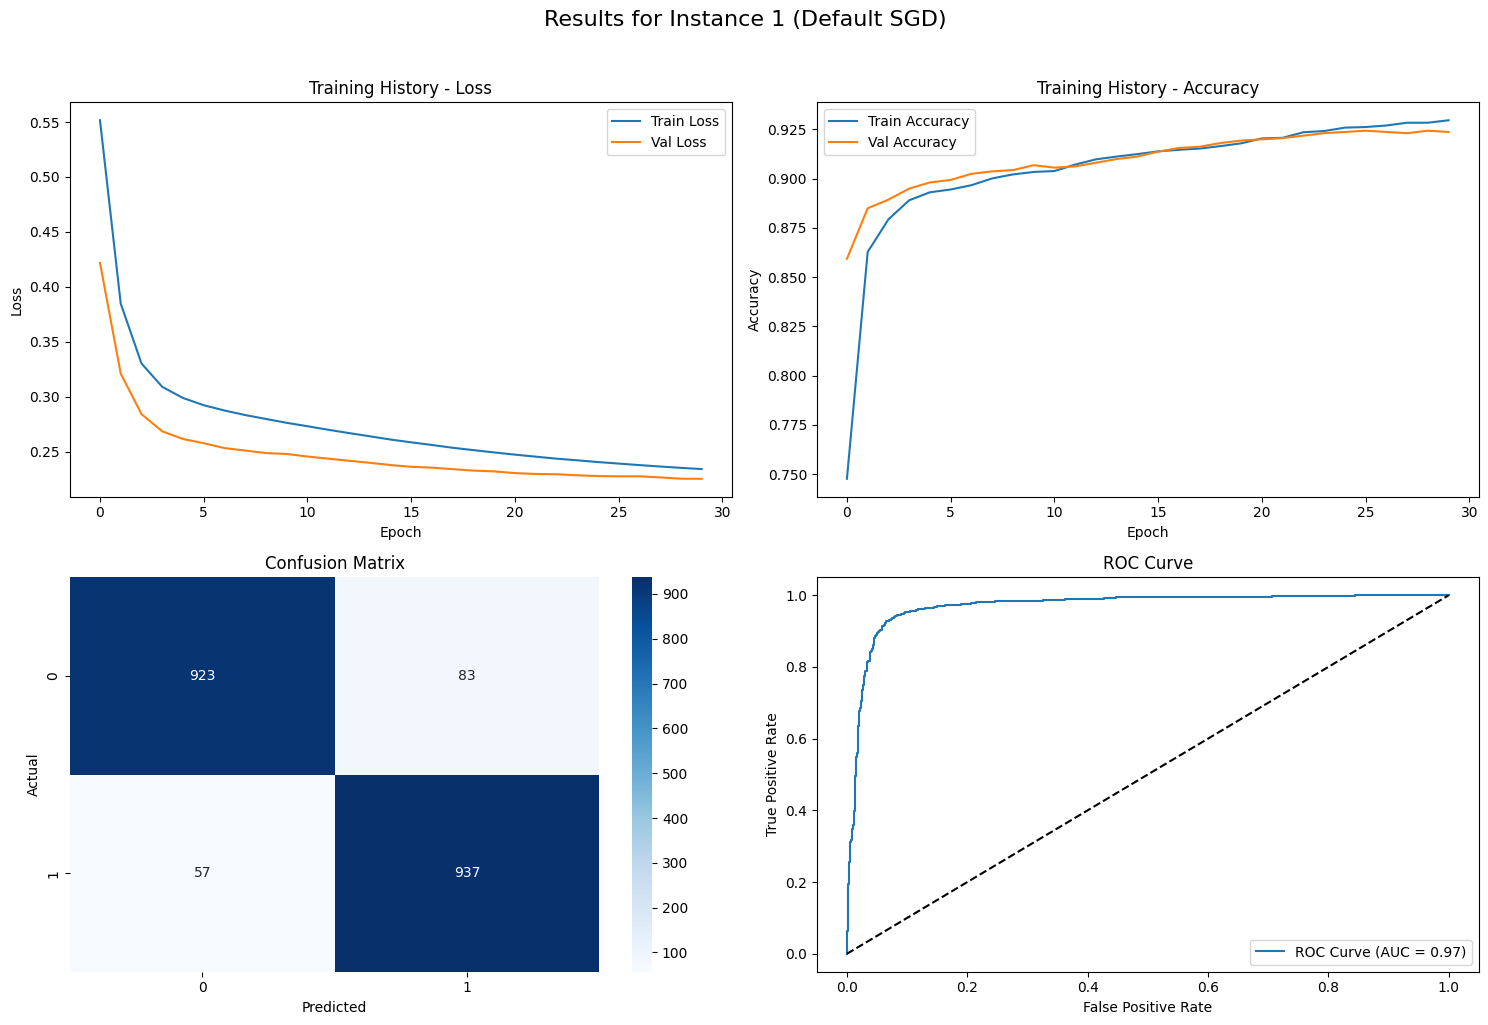


Classification Report for Instance 1 (Default SGD):
              precision    recall  f1-score   support

     Class 0       0.94      0.92      0.93      1006
     Class 1       0.92      0.94      0.93       994

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


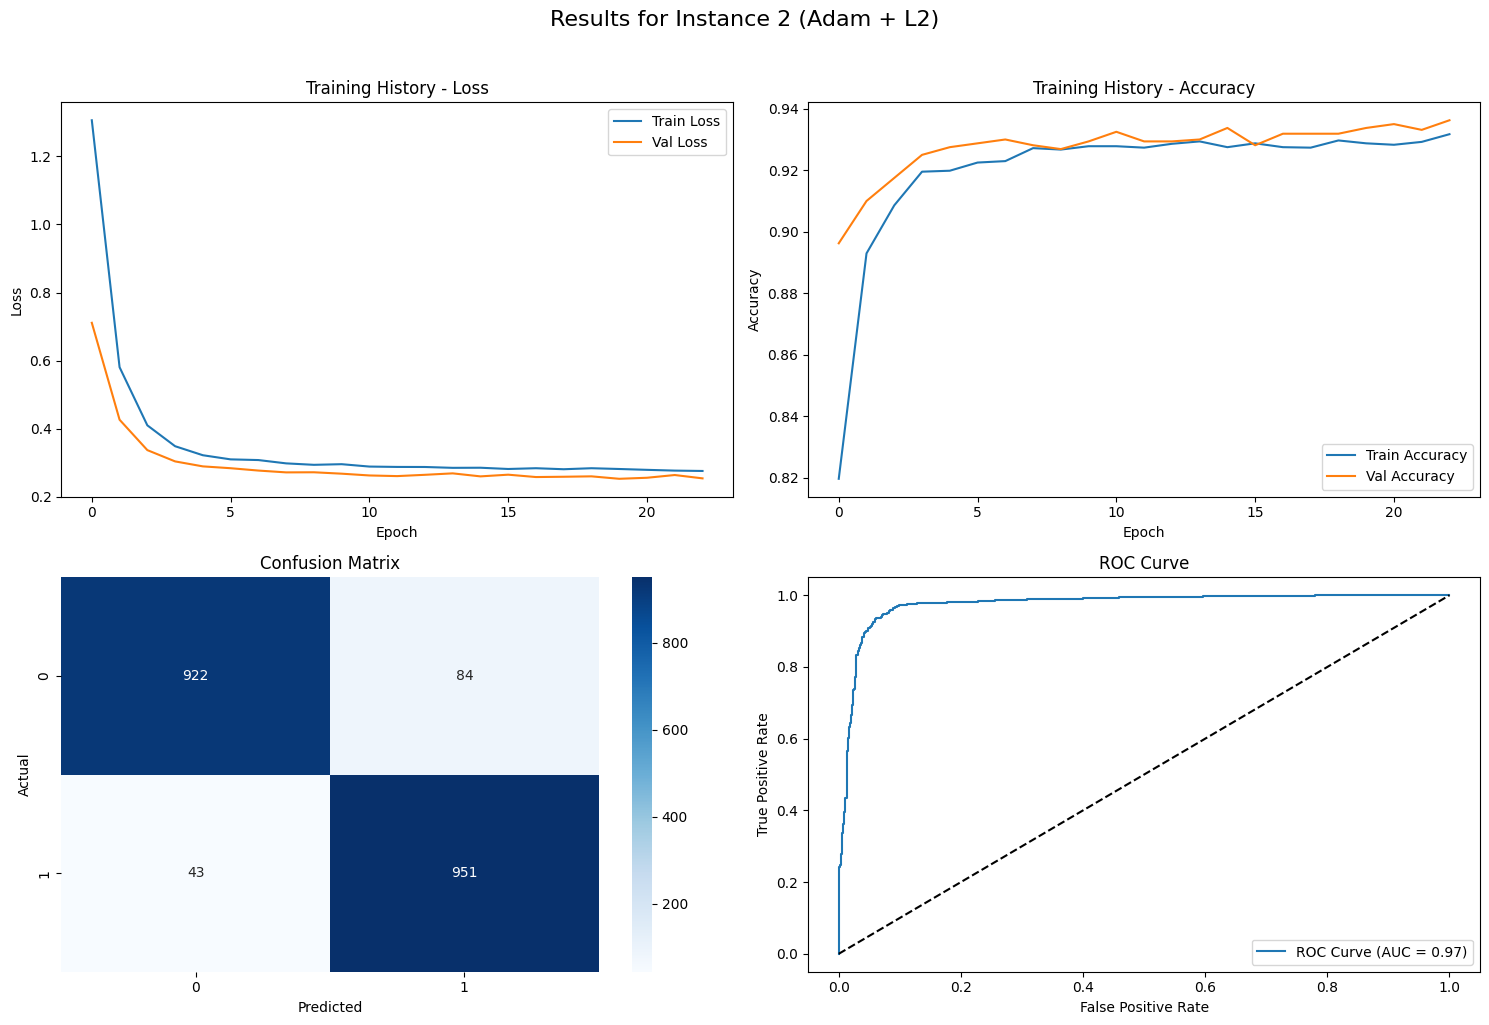


Classification Report for Instance 2 (Adam + L2):
              precision    recall  f1-score   support

     Class 0       0.96      0.92      0.94      1006
     Class 1       0.92      0.96      0.94       994

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


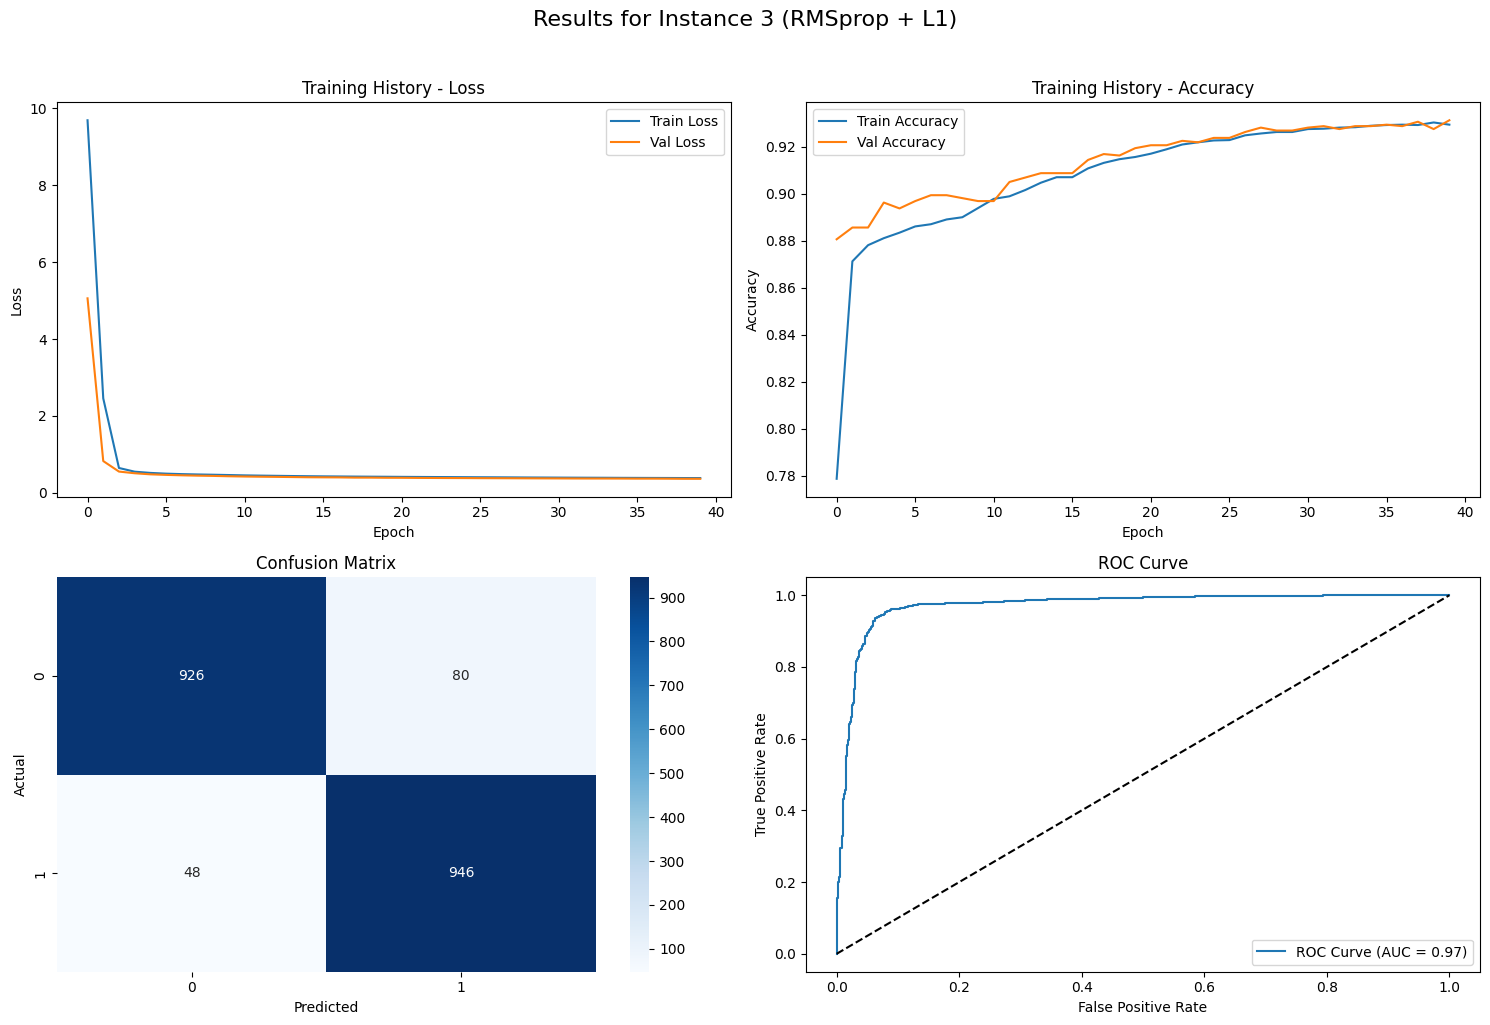


Classification Report for Instance 3 (RMSprop + L1):
              precision    recall  f1-score   support

     Class 0       0.95      0.92      0.94      1006
     Class 1       0.92      0.95      0.94       994

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



In [81]:
def plot_model_results(model, history, config, X_test, y_test):
    """Plot all results for a single model"""
    plt.figure(figsize=(15, 10))
    plt.suptitle(f"Results for {config['name']}", y=1.02, fontsize=16)

    # Training History
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training History - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Training History - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Confusion Matrix
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    plt.subplot(2, 2, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # ROC Curve
    y_pred_proba = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.subplot(2, 2, 4)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print metrics
    print(f"\nClassification Report for {config['name']}:")
    print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

# Plot each model separately
for model, history, config in zip(models, histories, configs):
    plot_model_results(model, history, config, X_test, y_test)

In [82]:
print("\n\nFINAL RESULTS COMPARISON")
print("="*110)
print("{:<10} | {:<12} | {:<10} | {:<8} | {:<6} | {:<8} | {:<8} | {:<8} | {:<8} | {:<8} | {:<8}".format(
    "Instance", "Optimizer", "Regularizer", "Epochs", "ES", "Layers", "LR", "Accuracy", "F1", "Precision", "ROC-AUC"
))
print("-"*110)

for res in results:
    cfg = res['config']
    m = res['metrics']
    print("{:<10} | {:<12} | {:<10} | {:<8} | {:<6} | {:<8} | {:<8} | {:<8.4f} | {:<8.4f} | {:<8.4f} | {:<8.4f}".format(
        f"Instance {res['instance']}",
        cfg['optimizer'] if cfg['optimizer'] else "Default",
        cfg['regularizer'] if cfg['regularizer'] else "None",
        res['epochs_trained'],
        "Yes" if cfg['early_stopping'] else "No",
        cfg['layers'],
        str(cfg['learning_rate']) if cfg['learning_rate'] else "Default",
        m['accuracy'],
        m['f1'],
        m['precision'],
        m['roc_auc']
    ))



FINAL RESULTS COMPARISON
Instance   | Optimizer    | Regularizer | Epochs   | ES     | Layers   | LR       | Accuracy | F1       | Precision | ROC-AUC 
--------------------------------------------------------------------------------------------------------------
Instance 1 | Default      | None       | 30       | No     | 3        | Default  | 0.9300   | 0.9305   | 0.9186   | 0.9696  
Instance 2 | Adam         | l2         | 23       | Yes    | 4        | 0.001    | 0.9365   | 0.9374   | 0.9188   | 0.9746  
Instance 3 | RMSprop      | l1         | 40       | No     | 5        | 0.0005   | 0.9360   | 0.9366   | 0.9220   | 0.9709  


#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [60]:
# =============================================================================
# Corrected RandomForest Implementation
# =============================================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 1. Verify shapes
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"y_train shape: {y_train.shape}")

# 2. If mismatch exists, re-split (example fix)
if X_train_scaled.shape[0] != y_train.shape[0]:
    print("\n⚠️ Shape mismatch detected. Re-creating splits...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

# 3. Proceed with RandomForest
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

rf_grid = GridSearchCV(
    rf_model, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1
)

print("\nTraining RandomForest...")
rf_grid.fit(X_train_scaled, y_train)  # Now shapes will match

# Evaluation
best_rf = rf_grid.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)
print(f"\nBest Params: {rf_grid.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")

X_train_scaled shape: (608, 8)
y_train shape: (8000,)

⚠️ Shape mismatch detected. Re-creating splits...

Training RandomForest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.9375
F1-Score: 0.9375


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Models saved successfully!
Evaluating Models...
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


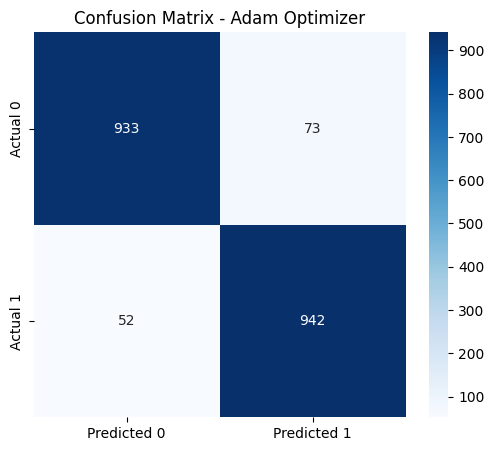


Adam Optimizer Evaluation:
F1 Score: 0.9378

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1006
           1       0.93      0.95      0.94       994

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


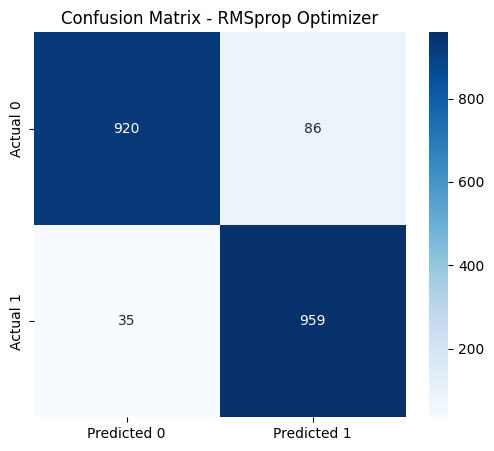


RMSprop Optimizer Evaluation:
F1 Score: 0.9407

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94      1006
           1       0.92      0.96      0.94       994

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



Best model is: RMSprop Optimizer (F1: 0.9407)

Making predictions with best model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

Sample predictions vs actual:
Predictions: [1 1 1 1 0]
Actual:      [1 1 1 1 0]

Best model summary:


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,459 (13.52 KB)

 Trainable params: 3,457 (13.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [61]:
import numpy as np
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
from tensorflow.keras.models import load_model, save_model
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


X, y = make_classification(n_samples=10000, n_features=20, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def create_model(optimizer='adam'):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(20,), kernel_regularizer='l2'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    if optimizer == 'adam':
        opt = Adam(learning_rate=0.001)
    else:
        opt = RMSprop(learning_rate=0.001)

    model.compile(optimizer=opt,
                loss='binary_crossentropy',
                metrics=['accuracy'])
    return model


model_2 = create_model('adam')
model_2.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

model_3 = create_model('rmsprop')
model_3.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# 3. Save models
model_2.save('best_model.h5')
model_3.save('rmsprop_model.h5')
print("Models saved successfully!")


def make_predictions(model_path, X):
    """Load saved model and make predictions"""
    model = load_model(model_path)
    predictions_prob = model.predict(X)
    return (predictions_prob > 0.5).astype(int)

def evaluate_model(model_path, X_test, y_test, model_name):
    """Evaluate model and display metrics"""
    y_pred = make_predictions(model_path, X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    # Metrics
    f1 = f1_score(y_test, y_pred)
    print(f"\n{model_name} Evaluation:")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return f1


print("Evaluating Models...\n" + "="*50)
f1_adam = evaluate_model('best_model.h5', X_test, y_test, "Adam Optimizer")

print("\n" + "="*50)
f1_rmsprop = evaluate_model('rmsprop_model.h5', X_test, y_test, "RMSprop Optimizer")


best_model_path = 'best_model.h5' if f1_adam > f1_rmsprop else 'rmsprop_model.h5'
best_model_name = "Adam Optimizer" if f1_adam > f1_rmsprop else "RMSprop Optimizer"
print("\n" + "="*50)
print(f"\nBest model is: {best_model_name} (F1: {max(f1_adam, f1_rmsprop):.4f})")


print("\nMaking predictions with best model...")
sample_data = X_test[:5]
predictions = make_predictions(best_model_path, sample_data)

print("\nSample predictions vs actual:")
print("Predictions:", predictions.flatten())
print("Actual:     ", y_test[:5])


print("\nBest model summary:")
best_model = load_model(best_model_path)
best_model.summary()

In [62]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

def make_predictions_with_metrics(model_path, X, y_true=None):
    """
    Make predictions and compute accuracy if true labels are provided

    Args:
        model_path: Path to saved model (.h5 file)
        X: Input data for prediction
        y_true: Ground truth labels (optional for accuracy calculation)

    Returns:
        Dictionary containing:
        - predictions: Array of predictions
        - accuracy: Accuracy score (if y_true provided)
        - error: Error message if any
    """
    result = {
        'predictions': None,
        'accuracy': None,
        'error': None
    }

    # Input validation
    if model_path is None:
        result['error'] = "Error: model_path cannot be None"
        return result

    if not isinstance(model_path, (str, bytes, os.PathLike)):
        result['error'] = f"Error: model_path must be string or path-like, got {type(model_path)}"
        return result

    if not os.path.exists(model_path):
        result['error'] = f"Error: Model file not found at {model_path}"
        return result

    try:
        # Load model and make predictions
        model = load_model(model_path)
        predictions_prob = model.predict(X, verbose=0)
        predictions = (predictions_prob > 0.5).astype(int)
        result['predictions'] = predictions

        # Calculate accuracy if true labels provided
        if y_true is not None:
            result['accuracy'] = accuracy_score(y_true, predictions)

        return result

    except Exception as e:
        result['error'] = f"Prediction failed: {str(e)}"
        return result

# Test with accuracy calculation
print("=== Testing with Accuracy Calculation ===")
test_data = X_test[:100]  # Using first 100 samples for demonstration
test_labels = y_test[:100]

results = make_predictions_with_metrics('best_model.h5', test_data, test_labels)

if results['error']:
    print(f"Error: {results['error']}")
else:
    print(f"Predictions shape: {results['predictions'].shape}")
    print(f"Model Accuracy: {results['accuracy']:.4f} ({results['accuracy']*100:.2f}%)")

    # Show first 10 predictions vs actual
    print("\nSample predictions vs actual:")
    print("Predictions:", results['predictions'][:10].flatten())
    print("Actual:     ", test_labels[:10])

=== Testing with Accuracy Calculation ===


Predictions shape: (100, 1)
Model Accuracy: 0.9500 (95.00%)

Sample predictions vs actual:
Predictions: [1 1 1 1 0 0 0 0 0 0]
Actual:      [1 1 1 1 0 0 0 0 0 0]


Congratulations!!
